In [37]:
from matminer.featurizers.composition import ElementFraction
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.core import Composition
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import ast 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.preprocessing import StandardScaler

import optuna

---- 
Initial Tests for getting compositional descriptors and Spacegroup Numbers.

In [38]:
df1 = pd.read_csv('./Data/1_MatDX/MatDX_nomad_EF_Binary.csv')
df2 = pd.read_csv('./Data/1_MatDX/MatDX_nomad_EF_Ternary.csv')

# Concatenate the DataFrames
df = pd.concat([df1, df2], ignore_index=True)

df.count()

formula             20000
space_group         20000
structure           20000
id                  20000
formation_energy    20000
dtype: int64

In [39]:
# Plot
plot_data = []

for sgletters in  df['space_group']: 
    
    sg = SpaceGroup(sgletters).int_number
    plot_data.append(sg)

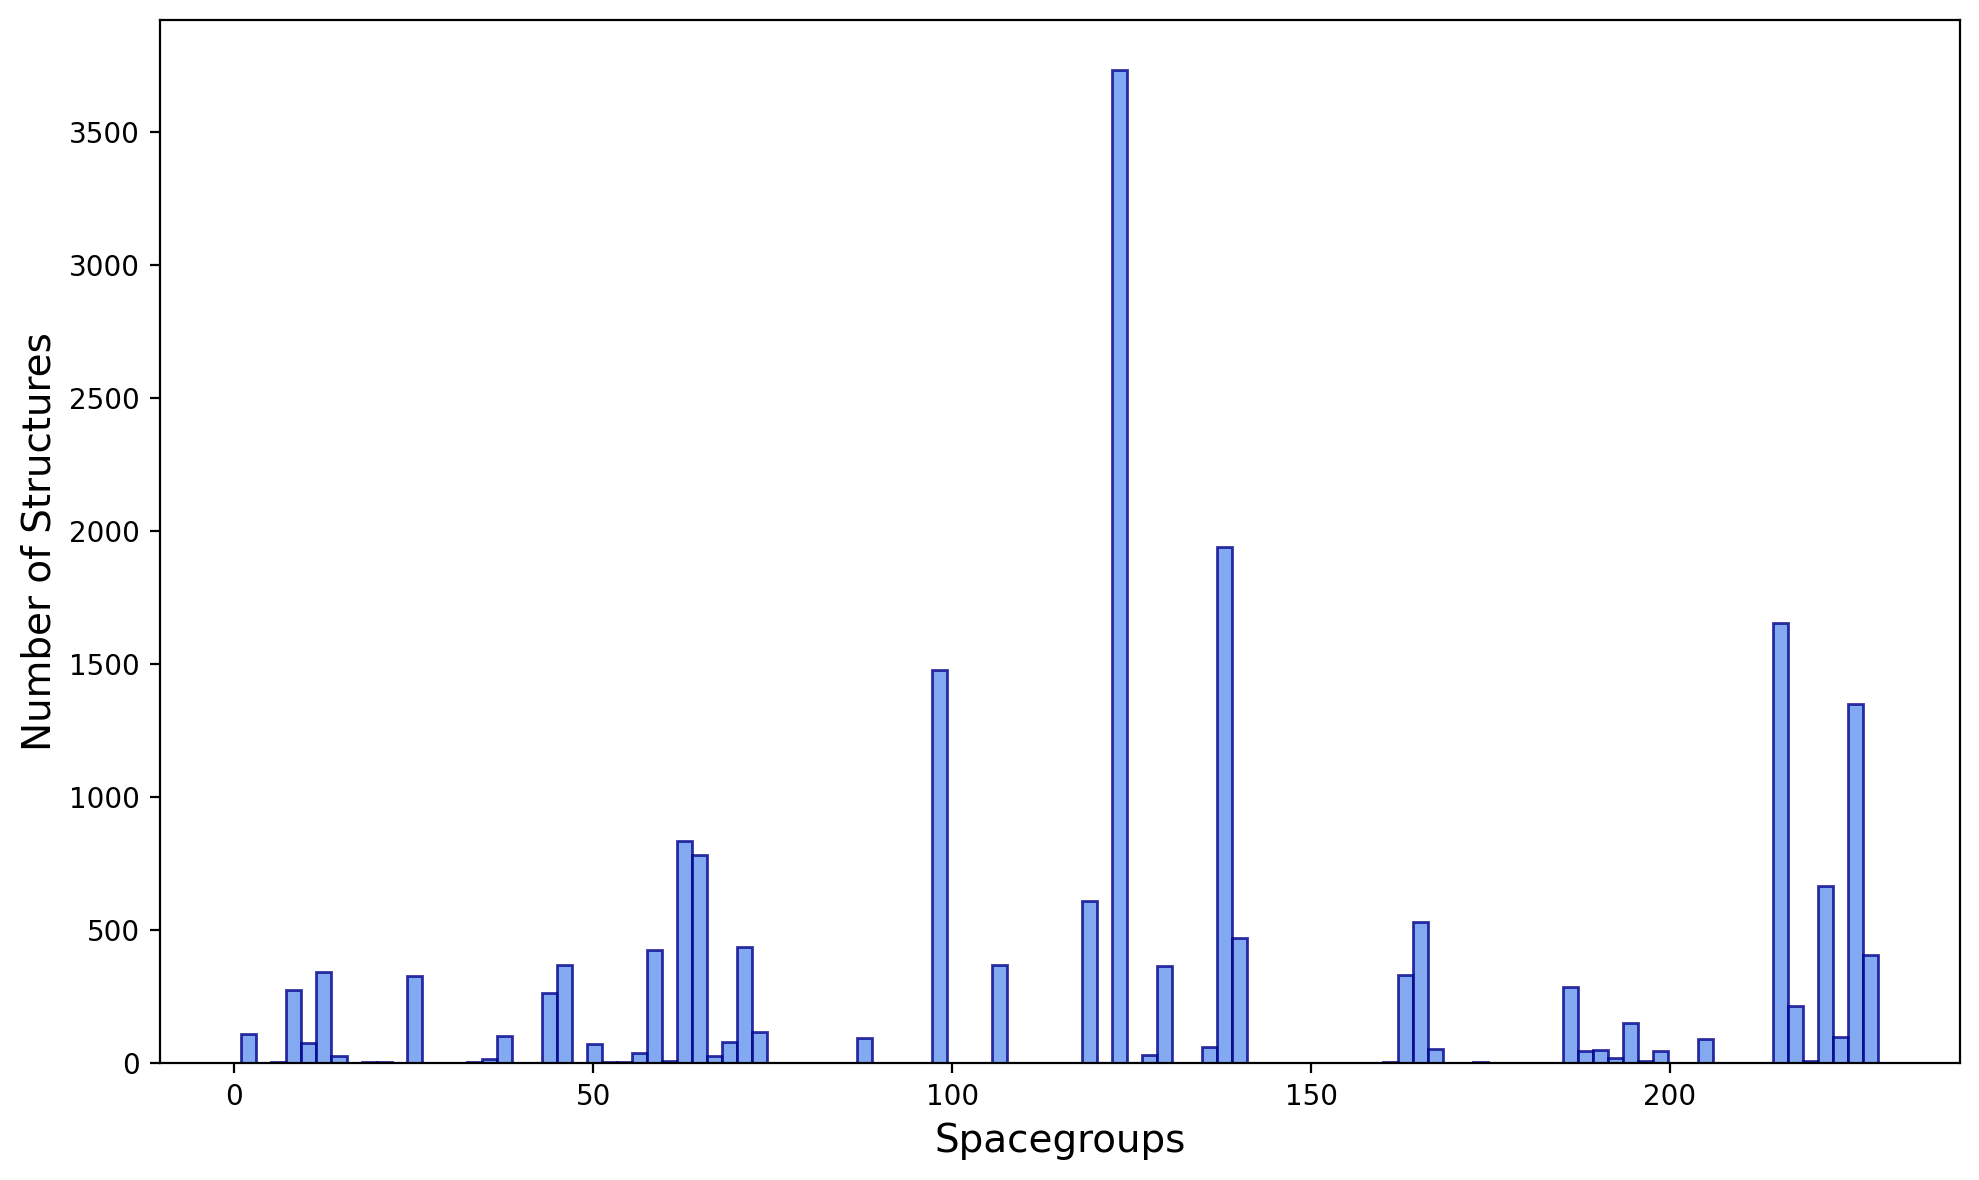

In [40]:
import matplotlib.pyplot as plt

# Calculate the number of bins based on unique values in the data
nbins = len(set(plot_data))

# Create the histogram
plt.figure(dpi=200, figsize=(10, 6))
plt.hist(plot_data, bins=nbins, color='cornflowerblue', edgecolor='darkblue', alpha=0.8)

# Labels and title
plt.xlabel('Spacegroups', fontsize=14)
plt.ylabel('Number of Structures', fontsize=14)


# Tight layout for cleaner appearance
plt.tight_layout()
plt.show()


In [41]:
def concatenate_lists(*lists):
    
    return  [item for lst in lists for item in lst]


def get_properties(row):

    
    data = ast.literal_eval(row['structure'])
    
    lattice_data = data[0]['data']
    
    lat_a, lat_b, lat_c = lattice_data['a'], lattice_data['b'], lattice_data['c']
    
    volume = abs(np.dot(lat_a, np.cross(lat_b, lat_c))) * 1e30
    e_f = ast.literal_eval(row['formation_energy'])['value']
    
    
    sg = SpaceGroup(row['space_group']).int_number
    
    return (volume, len(lattice_data['atoms']), sg, e_f)


def parity_plots(y_train, y_pred_train, y_test, y_pred):
    # Set up a side-by-side plot with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define min and max for the perfect prediction line across both plots
    min_val = min(y_train.min(), y_test.min())
    max_val = max(y_train.max(), y_test.max())

    # Training set parity plot
    ax1.scatter(y_train, y_pred_train, alpha=0.6, color="blue")
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # Perfect prediction line
    ax1.set_xlabel("Actual Values (Training)")
    ax1.set_ylabel("Predicted Values (Training)")
    ax1.set_title("Training Set Parity Plot")
    ax1.grid(True)

    # Test set parity plot
    ax2.scatter(y_test, y_pred, alpha=0.6, color="green")
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # Perfect prediction line
    ax2.set_xlabel("Actual Values (Test)")
    ax2.set_ylabel("Predicted Values (Test)")
    ax2.set_title("Test Set Parity Plot")
    ax2.grid(True)

    # Show the combined plot
    plt.tight_layout()
    plt.show()

In [42]:
descriptors = {}
target_property = {}

featurizer = ElementFraction()

for index, row in df.iterrows():
    
    try:
        volume, num_atoms, sg, e_f = get_properties(row)
        
        formula = row['formula']
        
        composition = Composition(formula)
        
        descriptor = featurizer.featurize(composition)
        
        descriptors[formula] = concatenate_lists(descriptor, [volume, num_atoms, sg])
        target_property[formula] = e_f
        
    except: 
        pass
        
print('The structure data are missing for :', df.count()['formula']- len(target_property.keys()))

The structure data are missing for : 10204


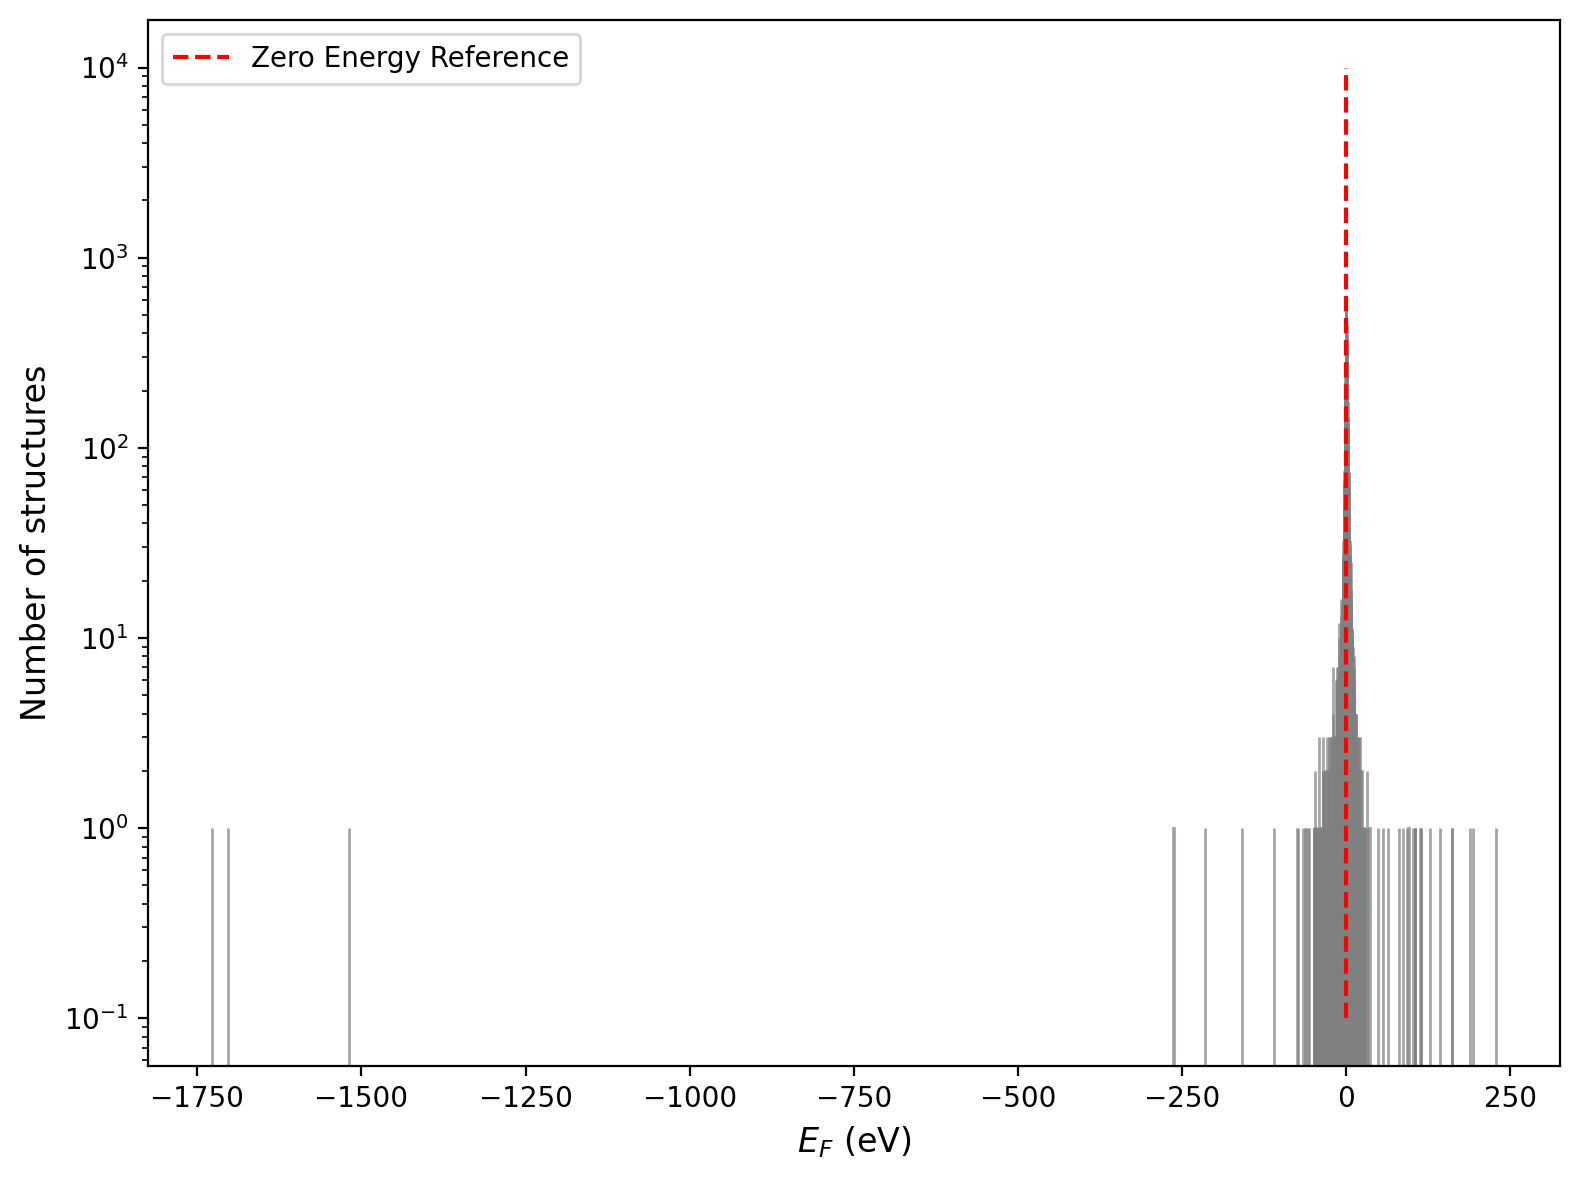

In [43]:
plt.figure(dpi=200, figsize=(8, 6))

# Plot histogram
plt.hist(list(target_property.values()), bins=10000, color='skyblue', edgecolor='gray', alpha=0.7)
plt.xlabel(r'$E_{F}$ (eV)', fontsize=12)
plt.ylabel('Number of structures', fontsize=12)

# Add vertical line at 0 with a label
plt.vlines(0, ymin=0.1, ymax=10000, colors='red', linestyles='dashed', label='Zero Energy Reference')
plt.legend(loc='upper left')

# Set y-axis to log scale
plt.yscale('log')

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

---- 
Too long descriptor. Let's shorten it. 

In [44]:
# Prepare the data. 

df_target = pd.Series(target_property, name='target')
df_descriptors = pd.DataFrame(descriptors).T

df = df_descriptors.join(df_target, how='inner')

X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
def objective(trial):
    # Define hyperparameters for XGBoost
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 1, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)

    # Optional dimensionality reduction with PCA
    n_components = trial.suggest_int("n_components", 10, min(X_train.shape[1], 30))

    # Create a pipeline with standard scaling, PCA, and the XGBRegressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('regressor', XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            min_child_weight=min_child_weight,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42
        ))
    ])

    # Use cross-validation to evaluate model performance
    r2 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(r2_score)).mean()
    
    return r2

# Run the Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best R-squared:", study.best_value)
print("Best hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params

[I 2024-11-07 08:12:01,399] A new study created in memory with name: no-name-42840a80-a8f7-4aa6-91c9-f00bbf83cce2
[I 2024-11-07 08:12:08,854] Trial 0 finished with value: -1.5694238241531189 and parameters: {'n_estimators': 428, 'max_depth': 7, 'learning_rate': 0.17474354511904627, 'subsample': 0.8796788927876412, 'colsample_bytree': 0.5580556885728478, 'min_child_weight': 7, 'reg_alpha': 0.5462036190457333, 'reg_lambda': 0.22159229644041523, 'n_components': 24}. Best is trial 0 with value: -1.5694238241531189.
[I 2024-11-07 08:12:14,297] Trial 1 finished with value: -1.4654207025745012 and parameters: {'n_estimators': 80, 'max_depth': 13, 'learning_rate': 0.1269013092715112, 'subsample': 0.767537480421087, 'colsample_bytree': 0.4213404552718625, 'min_child_weight': 1, 'reg_alpha': 0.6131358137605675, 'reg_lambda': 0.06590362518662529, 'n_components': 11}. Best is trial 1 with value: -1.4654207025745012.
[I 2024-11-07 08:12:15,782] Trial 2 finished with value: -0.9481299694370288 and p

Best R-squared: 0.0017001429132606828
Best hyperparameters: {'n_estimators': 64, 'max_depth': 12, 'learning_rate': 0.010027565883326187, 'subsample': 0.7557074143892908, 'colsample_bytree': 0.36093612191153507, 'min_child_weight': 9, 'reg_alpha': 0.7698681136888647, 'reg_lambda': 0.2577330624753044, 'n_components': 14}


In [36]:

# Set up final pipeline with optimized hyperparameters
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_params['n_components'])),
    ('regressor', RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    ))
])

# Fit the final model on the full training data
final_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = final_pipeline.predict(X_test)
r2_test = r2_score(y_test, y_pred)
print("Final model R-squared on test set:", r2_test)

NameError: name 'RandomForestRegressor' is not defined